In [1]:
#!conda install -n base -c conda-forge jupyterlab_widgets -y

In [2]:
# conda install -c conda-forge ipywidgets

In [3]:
import random

import matplotlib
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

# Set random seed
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [4]:
device

device(type='cuda', index=0)

In [5]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

In [6]:
def train_val_dataset(data):
    
    train_idx = []
    val_idx = []
    
    for i in range(len(data.classes)):
        all_idx = []
        
        for j in tqdm(range(len(data))):
            if i == data[j][1]:
                all_idx.append(j)
        
        split_idx = int(len(all_idx) * 0.8)
        
        train_idx = np.concatenate((train_idx, all_idx[:split_idx]))
        val_idx = np.concatenate((val_idx, all_idx[split_idx:]))
    
    datas = {}
    datas['train'] = Subset(data, list(map(int, train_idx)))
    datas['val'] = Subset(data, list(map(int, val_idx)))
    
    return datas

In [7]:
def data_aug(data, data_train, target):
    cls_idx = data.class_to_idx
    
    train_idx = []
    
    all_idx = []
    for i in tqdm(range(len(data))):
        
        if data[i][1] == cls_idx[target]:
            
            all_idx.append(i)
    
    split_idx = int(len(all_idx) * 0.8)
    
    train_idx = np.concatenate((train_idx, all_idx[:split_idx]))
    
    datas = Subset(data, list(map(int, train_idx)))
    datas_aug = torch.utils.data.ConcatDataset([data_train, datas])
    
    return datas_aug

In [8]:
'''
def train_val_dataset(data, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(data))), test_size=val_split, shuffle=False)
    datas = {}
    datas['train'] = Subset(data, train_idx)
    datas['val'] = Subset(data, val_idx)
    return datas
'''

"\ndef train_val_dataset(data, val_split=0.2):\n    train_idx, val_idx = train_test_split(list(range(len(data))), test_size=val_split, shuffle=False)\n    datas = {}\n    datas['train'] = Subset(data, train_idx)\n    datas['val'] = Subset(data, val_idx)\n    return datas\n"

In [9]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [10]:
test_dir = '/opt/ml/input/cropped_v2.1/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))

In [11]:
def model_run_age(target, sub_df, test_dir, learning_rate = 0.001):
    data_dir = f'/opt/ml/input/cropped_v2.1/train/images_classified_{target}/'
    
    dataset = datasets.ImageFolder(os.path.join(data_dir), transforms)
    
    print(f'*****{target}*****')
    print(dataset)
    print()
    
    class_names = dataset.classes
    print(class_names)
    print()
    
    print('****train, valid split****')
    dataset_split = train_val_dataset(dataset)
    
    print('****data augmentation****')
    dataset_aug = data_aug(dataset, dataset_split['train'], '2')
    
    dataloader = torch.utils.data.DataLoader(dataset_aug, batch_size=128, shuffle=True, num_workers=8)
    
    #dataloader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=128, shuffle=True, num_workers=8)
    valid_dataloader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=128, shuffle=False, num_workers=8)
    
    #model = models.resnet34(pretrained=True)
    model = models.resnet18(pretrained=True)
    
    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 18개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, len(class_names)) 
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.4)
    
    num_epochs = 50
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    print('****start epoch****')
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0
        
        all_labels = []
        all_preds = []
        
        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad() # 전체 grad 값을 초기화.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            all_preds.extend(preds.cpu().numpy())
            
            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_labels.extend(labels.data.cpu().numpy())

        epoch_loss = running_loss / len(dataset_aug)
        epoch_acc = running_corrects / len(dataset_aug) * 100.
        #epoch_loss = running_loss / len(dataset_split['train'])
        #epoch_acc = running_corrects / len(dataset_split['train']) * 100.
        F1_score_train = f1_score(all_labels, all_preds, average='macro')
        
        # validation
        model.eval()
        
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            
            for inputs, labels in valid_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
        
                all_preds.extend(preds.cpu().numpy())
        
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
                all_labels.extend(labels.data.cpu().numpy())
        
            valid_epoch_loss = running_loss / len(dataset_split['val'])
            valid_epoch_acc = running_corrects / len(dataset_split['val']) * 100.
            F1_score = f1_score(all_labels, all_preds, average='macro')
        
        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f} F1 Score: {:.4f} % Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, F1_score_train, time.time() - start_time))
        print(f'Valid Loss: {valid_epoch_loss:.4f} Valid Acc: {valid_epoch_acc:.4f} Valid F1 Score: {F1_score:.4f}')
    
    valid_preds = preds.cpu().numpy()
    valid_labels = labels.cpu().numpy()
    valid_inputs = inputs.cpu().numpy()
    
    
    image_dir = os.path.join(test_dir, 'images')
    
    image_paths = [os.path.join(image_dir, img_id) for img_id in sub_df.ImageID]
    
    test_set = TestDataset(image_paths, transforms)
    
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)
    
    all_predictions = []

    with torch.no_grad():
        for inputs in tqdm(test_dataloader):
            inputs = inputs.to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
            all_predictions.extend(preds.cpu().numpy())
    
    all_predictions2 = []

    for p in all_predictions:
        all_predictions2.append(class_names[p])
        
    sub_df[target] = all_predictions2
    
    return (sub_df, valid_preds, valid_labels, valid_inputs, dataset.classes)

In [12]:
def model_run(target, sub_df, test_dir, learning_rate = 0.001):
    data_dir = f'/opt/ml/input/cropped_v2.1/train/images_classified_{target}/'
    
    dataset = datasets.ImageFolder(os.path.join(data_dir), transforms)
    
    print(f'*****{target}*****')
    print(dataset)
    print()
    
    class_names = dataset.classes
    print(class_names)
    print()
    
    print('****train, valid split****')
    dataset_split = train_val_dataset(dataset)
    
    dataloader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=128, shuffle=True, num_workers=8)
    valid_dataloader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=128, shuffle=False, num_workers=8)
    
    model = models.resnet34(pretrained=True)

    num_features = model.fc.in_features
    # 전이 학습(transfer learning): 모델의 출력 뉴런 수를 18개로 교체하여 마지막 레이어 다시 학습
    model.fc = nn.Linear(num_features, len(class_names)) 
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    num_epochs = 10
    model.train()
    start_time = time.time()

    # 전체 반복(epoch) 수 만큼 반복하며
    print('****start epoch****')
    for epoch in range(num_epochs):
        running_loss = 0.
        running_corrects = 0

        # 배치 단위로 학습 데이터 불러오기
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 모델에 입력(forward)하고 결과 계산
            optimizer.zero_grad() # 전체 grad 값을 초기화.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataset_split['train'])
        epoch_acc = running_corrects / len(dataset_split['train']) * 100.
        F1_score_train = f1_score(all_labels, all_preds, average='macro')
        
        # validation
        model.eval()
        
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0
            
            for inputs, labels in valid_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
        
                all_preds.extend(preds.cpu().numpy())
        
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
                all_labels.extend(labels.data.cpu().numpy())
        
            valid_epoch_loss = running_loss / len(dataset_split['val'])
            valid_epoch_acc = running_corrects / len(dataset_split['val']) * 100.
            F1_score = f1_score(all_labels, all_preds, average='macro')
        
        # 학습 과정 중에 결과 출력
        print('#{} Loss: {:.4f} Acc: {:.4f} F1 Score: {:.4f} % Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, F1_score_train, time.time() - start_time))
        print(f'Valid Loss: {valid_epoch_loss:.4f} Valid Acc: {valid_epoch_acc:.4f} F1 Score: {F1_score:.4f}')
   
    valid_preds = preds.cpu().numpy()
    valid_labels = labels.cpu().numpy()
    valid_inputs = inputs.cpu().numpy()    
            
    image_dir = os.path.join(test_dir, 'images')
    
    image_paths = [os.path.join(image_dir, img_id) for img_id in sub_df.ImageID]
    
    test_set = TestDataset(image_paths, transforms)
    
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)
    
    all_predictions = []

    with torch.no_grad():
        for inputs in tqdm(test_dataloader):
            inputs = inputs.to(device)
        
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        
            all_predictions.extend(preds.cpu().numpy())
    
    all_predictions2 = []

    for p in all_predictions:
        all_predictions2.append(class_names[p])
        
    sub_df[target] = all_predictions2
    
    return (sub_df, valid_preds, valid_labels, valid_inputs, dataset.classes)

In [14]:
submission, v_p_m, v_l_m, v_i_m, m_c = model_run('mask', submission.copy(), test_dir)

  0%|          | 15/18900 [00:00<02:06, 148.77it/s]

*****mask*****
Dataset ImageFolder
    Number of datapoints: 18900
    Root location: /opt/ml/input/cropped_v2.1/train/images_classified_mask/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

['0', '12', '6']

****train, valid split****


  0%|          | 0/119 [00:00<?, ?it/s]

****start epoch****


  0%|          | 0/119 [00:00<?, ?it/s]

#0 Loss: 0.1692 Acc: 94.1733% Time: 31.7512s
Valid Loss: 0.0380 Valid Acc: 98.9947 F1 Score: 0.9832


  0%|          | 0/119 [00:00<?, ?it/s]

#1 Loss: 0.0150 Acc: 99.5900% Time: 63.2827s
Valid Loss: 0.0155 Valid Acc: 99.4974 F1 Score: 0.9919


  0%|          | 0/119 [00:00<?, ?it/s]

#2 Loss: 0.0044 Acc: 99.9008% Time: 94.6569s
Valid Loss: 0.0162 Valid Acc: 99.4974 F1 Score: 0.9920


  0%|          | 0/119 [00:00<?, ?it/s]

#3 Loss: 0.0013 Acc: 99.9735% Time: 125.9638s
Valid Loss: 0.0152 Valid Acc: 99.5238 F1 Score: 0.9925


  0%|          | 0/119 [00:00<?, ?it/s]

#4 Loss: 0.0005 Acc: 100.0000% Time: 157.2701s
Valid Loss: 0.0153 Valid Acc: 99.5503 F1 Score: 0.9929


  0%|          | 0/119 [00:00<?, ?it/s]

#5 Loss: 0.0003 Acc: 100.0000% Time: 188.6712s
Valid Loss: 0.0144 Valid Acc: 99.6032 F1 Score: 0.9937


  0%|          | 0/119 [00:00<?, ?it/s]

#6 Loss: 0.0002 Acc: 100.0000% Time: 220.0270s
Valid Loss: 0.0152 Valid Acc: 99.5503 F1 Score: 0.9929


  0%|          | 0/119 [00:00<?, ?it/s]

#7 Loss: 0.0001 Acc: 100.0000% Time: 251.3303s
Valid Loss: 0.0152 Valid Acc: 99.6032 F1 Score: 0.9937


  0%|          | 0/119 [00:00<?, ?it/s]

#8 Loss: 0.0001 Acc: 100.0000% Time: 282.7794s
Valid Loss: 0.0150 Valid Acc: 99.6032 F1 Score: 0.9937


  0%|          | 0/99 [00:00<?, ?it/s]

#9 Loss: 0.0001 Acc: 100.0000% Time: 314.0912s
Valid Loss: 0.0156 Valid Acc: 99.6032 F1 Score: 0.9937


100%|██████████| 99/99 [00:09<00:00, 10.75it/s]


pred: 0 label: 6


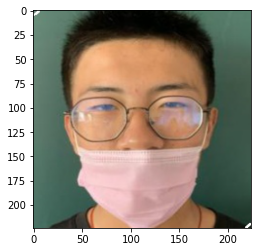

pred: 0 label: 6


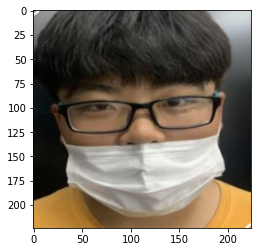

In [15]:
for p, l, im in zip(v_p_m, v_l_m, v_i_m):
    if p != l:
        pred = m_c[p]
        label = m_c[l]
        
        im = im.transpose((1, 2, 0))
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        im = np.clip(im, 0, 1)
        
        print(f'pred: {pred} label: {label}')
        plt.imshow(im)
        plt.show()

In [16]:
submission, v_p_g, v_l_g, v_i_g, g_c = model_run('gender', submission.copy(), test_dir)

  0%|          | 32/18900 [00:00<01:00, 312.31it/s]

*****gender*****
Dataset ImageFolder
    Number of datapoints: 18900
    Root location: /opt/ml/input/cropped_v2.1/train/images_classified_gender/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

['0', '3']

****train, valid split****


  0%|          | 0/119 [00:00<?, ?it/s]

****start epoch****


  0%|          | 0/119 [00:00<?, ?it/s]

#0 Loss: 0.2012 Acc: 92.1754% Time: 31.8476s
Valid Loss: 0.0836 Valid Acc: 97.3023 F1 Score: 0.9716


  0%|          | 0/119 [00:00<?, ?it/s]

#1 Loss: 0.0551 Acc: 98.1943% Time: 63.2434s
Valid Loss: 0.1593 Valid Acc: 93.8905 F1 Score: 0.9337


  0%|          | 0/119 [00:00<?, ?it/s]

#2 Loss: 0.0321 Acc: 98.9417% Time: 94.4319s
Valid Loss: 0.0779 Valid Acc: 97.3552 F1 Score: 0.9721


  0%|          | 0/119 [00:00<?, ?it/s]

#3 Loss: 0.0062 Acc: 99.8016% Time: 125.5847s
Valid Loss: 0.1111 Valid Acc: 96.4824 F1 Score: 0.9633


  0%|          | 0/119 [00:00<?, ?it/s]

#4 Loss: 0.0023 Acc: 99.9537% Time: 156.7130s
Valid Loss: 0.0880 Valid Acc: 97.5403 F1 Score: 0.9741


  0%|          | 0/119 [00:00<?, ?it/s]

#5 Loss: 0.0004 Acc: 100.0000% Time: 187.9827s
Valid Loss: 0.0959 Valid Acc: 97.5139 F1 Score: 0.9737


  0%|          | 0/119 [00:00<?, ?it/s]

#6 Loss: 0.0002 Acc: 100.0000% Time: 219.1329s
Valid Loss: 0.0994 Valid Acc: 97.4345 F1 Score: 0.9730


  0%|          | 0/119 [00:00<?, ?it/s]

#7 Loss: 0.0001 Acc: 100.0000% Time: 250.4346s
Valid Loss: 0.1026 Valid Acc: 97.4610 F1 Score: 0.9733


  0%|          | 0/119 [00:00<?, ?it/s]

#8 Loss: 0.0001 Acc: 100.0000% Time: 281.9524s
Valid Loss: 0.1055 Valid Acc: 97.4610 F1 Score: 0.9732


  0%|          | 0/99 [00:00<?, ?it/s]

#9 Loss: 0.0001 Acc: 100.0000% Time: 313.2275s
Valid Loss: 0.1079 Valid Acc: 97.4081 F1 Score: 0.9727


100%|██████████| 99/99 [00:09<00:00, 10.80it/s]


pred: 0 label: 3


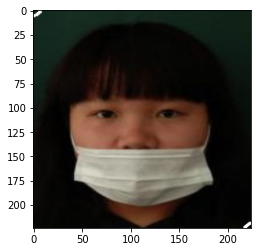

pred: 0 label: 3


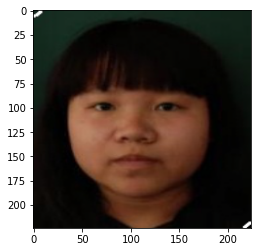

In [17]:
for p, l, im in zip(v_p_g, v_l_g, v_i_g):
    if p != l:
        pred = g_c[p]
        label = g_c[l]
        
        im = im.transpose((1, 2, 0))
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        im = np.clip(im, 0, 1)
        
        print(f'pred: {pred} label: {label}')
        plt.imshow(im)
        plt.show()

In [18]:
submission, v_p_a, v_l_a, v_i_a, a_c = model_run_age('age', submission.copy(), test_dir, 0.00007)

  0%|          | 32/18900 [00:00<01:00, 313.98it/s]

*****age*****
Dataset ImageFolder
    Number of datapoints: 18900
    Root location: /opt/ml/input/cropped_v2.1/train/images_classified_age/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

['0', '1', '2']

****train, valid split****


  0%|          | 33/18900 [00:00<00:57, 326.65it/s]

****data augmentation****


  0%|          | 0/127 [00:00<?, ?it/s]

****start epoch****


  0%|          | 0/127 [00:00<?, ?it/s]

#0 Loss: 1.0329 Acc: 45.0784 F1 Score: 0.3287 % Time: 23.7580s
Valid Loss: 0.9156 Valid Acc: 55.5938 Valid F1 Score: 0.3977


  0%|          | 0/127 [00:00<?, ?it/s]

#1 Loss: 0.8644 Acc: 62.7331 F1 Score: 0.4602 % Time: 46.9755s
Valid Loss: 0.7937 Valid Acc: 65.0622 Valid F1 Score: 0.4579


  0%|          | 0/127 [00:00<?, ?it/s]

#2 Loss: 0.6952 Acc: 74.8672 F1 Score: 0.5711 % Time: 70.3059s
Valid Loss: 0.7207 Valid Acc: 69.3996 Valid F1 Score: 0.5048


  0%|          | 0/127 [00:00<?, ?it/s]

#3 Loss: 0.5661 Acc: 79.8876 F1 Score: 0.6508 % Time: 93.5358s
Valid Loss: 0.6614 Valid Acc: 72.0709 Valid F1 Score: 0.5429


  0%|          | 0/127 [00:00<?, ?it/s]

#4 Loss: 0.4773 Acc: 82.6232 F1 Score: 0.7070 % Time: 116.8610s
Valid Loss: 0.6176 Valid Acc: 74.8215 Valid F1 Score: 0.5826


  0%|          | 0/127 [00:00<?, ?it/s]

#5 Loss: 0.4193 Acc: 84.4016 F1 Score: 0.7479 % Time: 140.2091s
Valid Loss: 0.5951 Valid Acc: 75.9323 Valid F1 Score: 0.6163


  0%|          | 0/127 [00:00<?, ?it/s]

#6 Loss: 0.3807 Acc: 85.5564 F1 Score: 0.7745 % Time: 163.5504s
Valid Loss: 0.5955 Valid Acc: 76.3026 Valid F1 Score: 0.6270


  0%|          | 0/127 [00:00<?, ?it/s]

#7 Loss: 0.3538 Acc: 86.1862 F1 Score: 0.7861 % Time: 186.8564s
Valid Loss: 0.5633 Valid Acc: 77.5192 Valid F1 Score: 0.6422


  0%|          | 0/127 [00:00<?, ?it/s]

#8 Loss: 0.3341 Acc: 86.8099 F1 Score: 0.7991 % Time: 210.0780s
Valid Loss: 0.5333 Valid Acc: 79.1061 Valid F1 Score: 0.6633


  0%|          | 0/127 [00:00<?, ?it/s]

#9 Loss: 0.3190 Acc: 87.1681 F1 Score: 0.8073 % Time: 233.2029s
Valid Loss: 0.5382 Valid Acc: 78.7358 Valid F1 Score: 0.6598


  0%|          | 0/127 [00:00<?, ?it/s]

#10 Loss: 0.3067 Acc: 87.6806 F1 Score: 0.8160 % Time: 256.3518s
Valid Loss: 0.5405 Valid Acc: 78.9738 Valid F1 Score: 0.6652


  0%|          | 0/127 [00:00<?, ?it/s]

#11 Loss: 0.2962 Acc: 88.1067 F1 Score: 0.8229 % Time: 279.4974s
Valid Loss: 0.5590 Valid Acc: 78.5242 Valid F1 Score: 0.6661


  0%|          | 0/127 [00:00<?, ?it/s]

#12 Loss: 0.2872 Acc: 88.4525 F1 Score: 0.8291 % Time: 302.7279s
Valid Loss: 0.5493 Valid Acc: 79.0267 Valid F1 Score: 0.6760


  0%|          | 0/127 [00:00<?, ?it/s]

#13 Loss: 0.2795 Acc: 88.7119 F1 Score: 0.8333 % Time: 325.8026s
Valid Loss: 0.5243 Valid Acc: 79.9259 Valid F1 Score: 0.6777


  0%|          | 0/127 [00:00<?, ?it/s]

#14 Loss: 0.2724 Acc: 89.0453 F1 Score: 0.8381 % Time: 349.0365s
Valid Loss: 0.5381 Valid Acc: 79.6086 Valid F1 Score: 0.6812


  0%|          | 0/127 [00:00<?, ?it/s]

#15 Loss: 0.2663 Acc: 89.2429 F1 Score: 0.8416 % Time: 372.3059s
Valid Loss: 0.5228 Valid Acc: 80.2433 Valid F1 Score: 0.6865


  0%|          | 0/127 [00:00<?, ?it/s]

#16 Loss: 0.2602 Acc: 89.6999 F1 Score: 0.8483 % Time: 395.4608s
Valid Loss: 0.5541 Valid Acc: 79.4234 Valid F1 Score: 0.6764


  0%|          | 0/127 [00:00<?, ?it/s]

#17 Loss: 0.2553 Acc: 89.9037 F1 Score: 0.8512 % Time: 418.6765s
Valid Loss: 0.5232 Valid Acc: 80.5342 Valid F1 Score: 0.6930


  0%|          | 0/127 [00:00<?, ?it/s]

#18 Loss: 0.2501 Acc: 90.0333 F1 Score: 0.8541 % Time: 441.7427s
Valid Loss: 0.5706 Valid Acc: 79.0532 Valid F1 Score: 0.6776


  0%|          | 0/127 [00:00<?, ?it/s]

#19 Loss: 0.2450 Acc: 90.2803 F1 Score: 0.8568 % Time: 464.8974s
Valid Loss: 0.5827 Valid Acc: 78.9738 Valid F1 Score: 0.6829


  0%|          | 0/127 [00:00<?, ?it/s]

#20 Loss: 0.2409 Acc: 90.4903 F1 Score: 0.8604 % Time: 488.2609s
Valid Loss: 0.4959 Valid Acc: 81.5128 Valid F1 Score: 0.6980


  0%|          | 0/127 [00:00<?, ?it/s]

#21 Loss: 0.2364 Acc: 90.6323 F1 Score: 0.8630 % Time: 511.4204s
Valid Loss: 0.5102 Valid Acc: 81.3541 Valid F1 Score: 0.7002


  0%|          | 0/127 [00:00<?, ?it/s]

#22 Loss: 0.2324 Acc: 90.7744 F1 Score: 0.8649 % Time: 534.7100s
Valid Loss: 0.5495 Valid Acc: 80.2169 Valid F1 Score: 0.6953


  0%|          | 0/127 [00:00<?, ?it/s]

#23 Loss: 0.2286 Acc: 91.0769 F1 Score: 0.8692 % Time: 558.0291s
Valid Loss: 0.4928 Valid Acc: 82.0418 Valid F1 Score: 0.7075


  0%|          | 0/127 [00:00<?, ?it/s]

#24 Loss: 0.2247 Acc: 91.2251 F1 Score: 0.8719 % Time: 581.2150s
Valid Loss: 0.5375 Valid Acc: 80.9045 Valid F1 Score: 0.7030


  0%|          | 0/127 [00:00<?, ?it/s]

#25 Loss: 0.2213 Acc: 91.2745 F1 Score: 0.8724 % Time: 604.5083s
Valid Loss: 0.5588 Valid Acc: 80.2169 Valid F1 Score: 0.6972


  0%|          | 0/127 [00:00<?, ?it/s]

#26 Loss: 0.2177 Acc: 91.5648 F1 Score: 0.8766 % Time: 627.7380s
Valid Loss: 0.5303 Valid Acc: 81.2484 Valid F1 Score: 0.7023


  0%|          | 0/127 [00:00<?, ?it/s]

#27 Loss: 0.2151 Acc: 91.6389 F1 Score: 0.8780 % Time: 650.7628s
Valid Loss: 0.5394 Valid Acc: 81.1426 Valid F1 Score: 0.7064


  0%|          | 0/127 [00:00<?, ?it/s]

#28 Loss: 0.2113 Acc: 91.8427 F1 Score: 0.8811 % Time: 673.8741s
Valid Loss: 0.5441 Valid Acc: 81.0632 Valid F1 Score: 0.7057


  0%|          | 0/127 [00:00<?, ?it/s]

#29 Loss: 0.2077 Acc: 92.0032 F1 Score: 0.8830 % Time: 697.0409s
Valid Loss: 0.5833 Valid Acc: 79.6350 Valid F1 Score: 0.6976


  0%|          | 0/127 [00:00<?, ?it/s]

#30 Loss: 0.2053 Acc: 92.1267 F1 Score: 0.8860 % Time: 720.5503s
Valid Loss: 0.5466 Valid Acc: 81.2748 Valid F1 Score: 0.7085


  0%|          | 0/127 [00:00<?, ?it/s]

#31 Loss: 0.2024 Acc: 92.2749 F1 Score: 0.8875 % Time: 743.7289s
Valid Loss: 0.5355 Valid Acc: 81.5128 Valid F1 Score: 0.7126


  0%|          | 0/127 [00:00<?, ?it/s]

#32 Loss: 0.1994 Acc: 92.3552 F1 Score: 0.8887 % Time: 766.9627s
Valid Loss: 0.5727 Valid Acc: 80.2962 Valid F1 Score: 0.7029


  0%|          | 0/127 [00:00<?, ?it/s]

#33 Loss: 0.1963 Acc: 92.5713 F1 Score: 0.8919 % Time: 790.0838s
Valid Loss: 0.5363 Valid Acc: 81.5922 Valid F1 Score: 0.7127


  0%|          | 0/127 [00:00<?, ?it/s]

#34 Loss: 0.1938 Acc: 92.5713 F1 Score: 0.8914 % Time: 813.2112s
Valid Loss: 0.5229 Valid Acc: 81.9360 Valid F1 Score: 0.7165


  0%|          | 0/127 [00:00<?, ?it/s]

#35 Loss: 0.1911 Acc: 92.6825 F1 Score: 0.8938 % Time: 836.3786s
Valid Loss: 0.4837 Valid Acc: 83.1791 Valid F1 Score: 0.7267


  0%|          | 0/127 [00:00<?, ?it/s]

#36 Loss: 0.1888 Acc: 92.7813 F1 Score: 0.8942 % Time: 859.6693s
Valid Loss: 0.5557 Valid Acc: 81.3277 Valid F1 Score: 0.7115


  0%|          | 0/127 [00:00<?, ?it/s]

#37 Loss: 0.1859 Acc: 92.9171 F1 Score: 0.8960 % Time: 882.8685s
Valid Loss: 0.5349 Valid Acc: 81.9095 Valid F1 Score: 0.7184


  0%|          | 0/127 [00:00<?, ?it/s]

#38 Loss: 0.1834 Acc: 92.9171 F1 Score: 0.8965 % Time: 905.9777s
Valid Loss: 0.5268 Valid Acc: 82.2005 Valid F1 Score: 0.7192


  0%|          | 0/127 [00:00<?, ?it/s]

#39 Loss: 0.1807 Acc: 93.1024 F1 Score: 0.8992 % Time: 929.2603s
Valid Loss: 0.5433 Valid Acc: 81.7244 Valid F1 Score: 0.7190


  0%|          | 0/127 [00:00<?, ?it/s]

#40 Loss: 0.1784 Acc: 93.0900 F1 Score: 0.8995 % Time: 952.3380s
Valid Loss: 0.6039 Valid Acc: 80.1904 Valid F1 Score: 0.7004


  0%|          | 0/127 [00:00<?, ?it/s]

#41 Loss: 0.1762 Acc: 93.2259 F1 Score: 0.9008 % Time: 975.4431s
Valid Loss: 0.6088 Valid Acc: 79.8466 Valid F1 Score: 0.7019


  0%|          | 0/127 [00:00<?, ?it/s]

#42 Loss: 0.1741 Acc: 93.3000 F1 Score: 0.9019 % Time: 998.4996s
Valid Loss: 0.5368 Valid Acc: 82.2269 Valid F1 Score: 0.7212


  0%|          | 0/127 [00:00<?, ?it/s]

#43 Loss: 0.1712 Acc: 93.4667 F1 Score: 0.9043 % Time: 1021.8061s
Valid Loss: 0.5101 Valid Acc: 82.9939 Valid F1 Score: 0.7299


  0%|          | 0/127 [00:00<?, ?it/s]

#44 Loss: 0.1689 Acc: 93.5223 F1 Score: 0.9053 % Time: 1045.0207s
Valid Loss: 0.5328 Valid Acc: 82.5707 Valid F1 Score: 0.7254


  0%|          | 0/127 [00:00<?, ?it/s]

#45 Loss: 0.1667 Acc: 93.6890 F1 Score: 0.9074 % Time: 1068.3007s
Valid Loss: 0.5275 Valid Acc: 82.7559 Valid F1 Score: 0.7277


  0%|          | 0/127 [00:00<?, ?it/s]

#46 Loss: 0.1644 Acc: 93.8063 F1 Score: 0.9097 % Time: 1091.3307s
Valid Loss: 0.5370 Valid Acc: 82.3327 Valid F1 Score: 0.7229


  0%|          | 0/127 [00:00<?, ?it/s]

#47 Loss: 0.1623 Acc: 93.7569 F1 Score: 0.9087 % Time: 1114.4906s
Valid Loss: 0.5557 Valid Acc: 82.0682 Valid F1 Score: 0.7219


  0%|          | 0/127 [00:00<?, ?it/s]

#48 Loss: 0.1603 Acc: 93.8249 F1 Score: 0.9106 % Time: 1137.6772s
Valid Loss: 0.5274 Valid Acc: 82.9410 Valid F1 Score: 0.7277


  0%|          | 0/99 [00:00<?, ?it/s]

#49 Loss: 0.1579 Acc: 93.9978 F1 Score: 0.9126 % Time: 1160.7892s
Valid Loss: 0.5720 Valid Acc: 81.9889 Valid F1 Score: 0.7206


100%|██████████| 99/99 [00:07<00:00, 13.28it/s]


pred: 1 label: 2


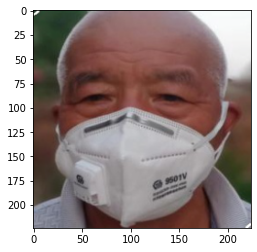

pred: 1 label: 2


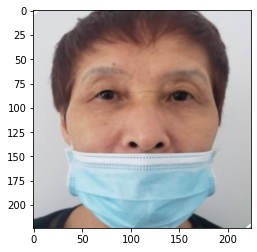

pred: 1 label: 2


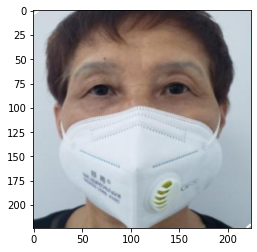

pred: 1 label: 2


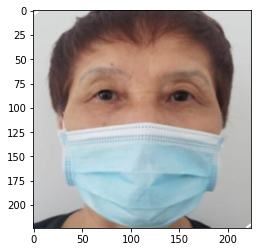

pred: 1 label: 2


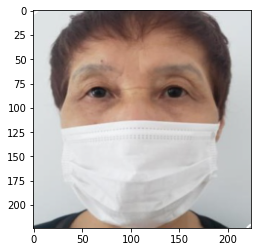

pred: 1 label: 2


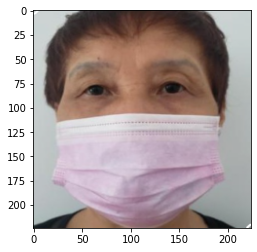

pred: 1 label: 2


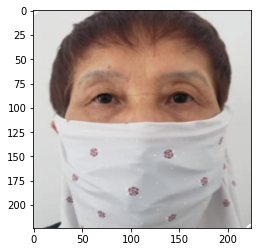

pred: 1 label: 2


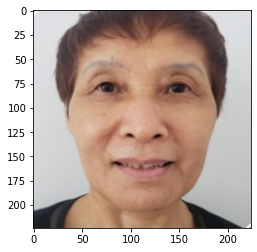

pred: 1 label: 2


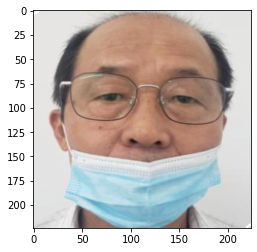

pred: 1 label: 2


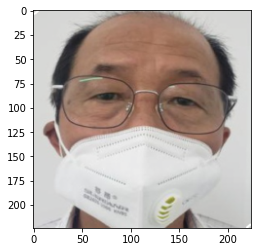

pred: 1 label: 2


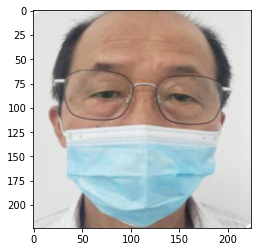

pred: 1 label: 2


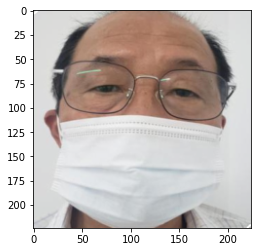

pred: 1 label: 2


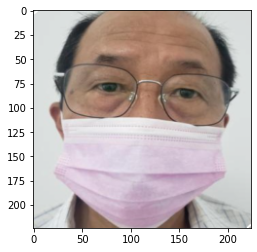

pred: 1 label: 2


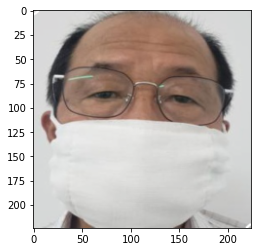

pred: 1 label: 2


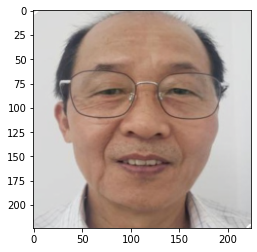

pred: 1 label: 2


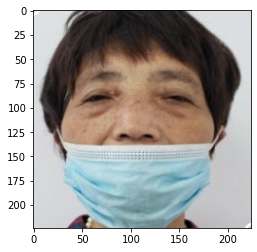

pred: 1 label: 2


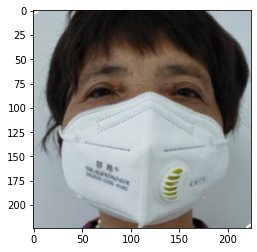

pred: 1 label: 2


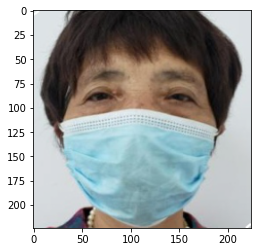

pred: 1 label: 2


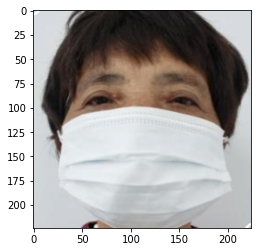

pred: 1 label: 2


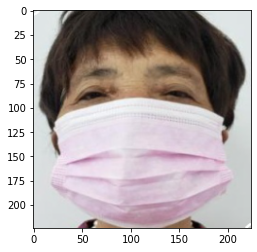

pred: 1 label: 2


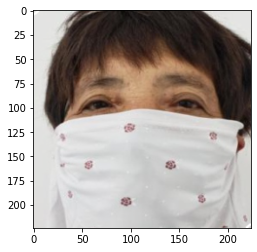

pred: 1 label: 2


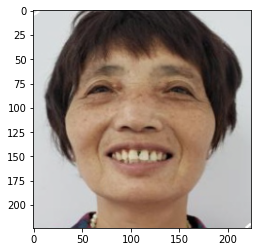

pred: 1 label: 2


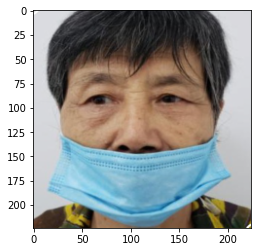

pred: 1 label: 2


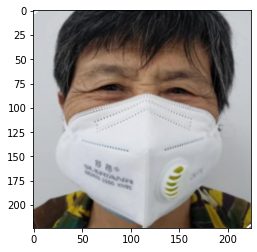

pred: 1 label: 2


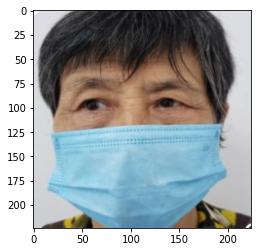

pred: 1 label: 2


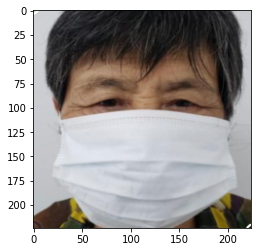

pred: 1 label: 2


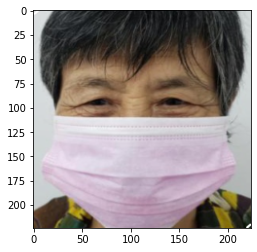

pred: 1 label: 2


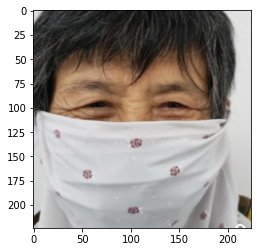

pred: 1 label: 2


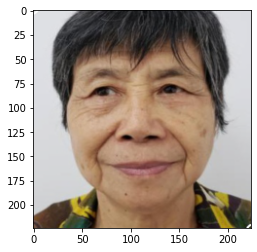

pred: 1 label: 2


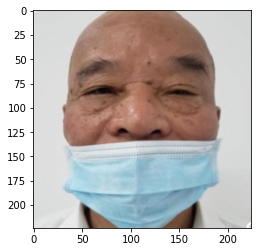

pred: 1 label: 2


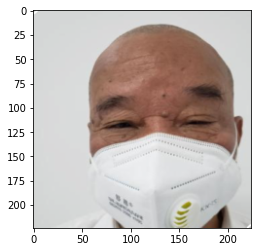

pred: 1 label: 2


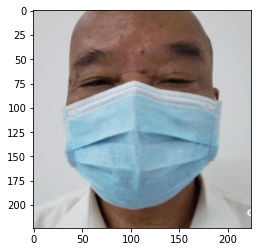

pred: 1 label: 2


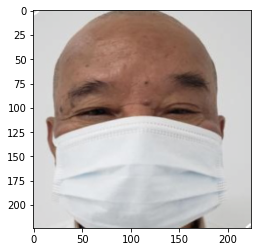

pred: 1 label: 2


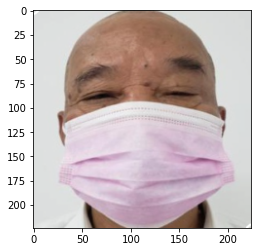

pred: 1 label: 2


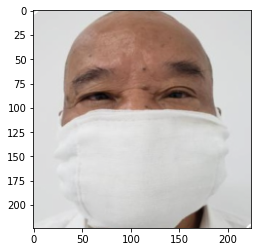

pred: 1 label: 2


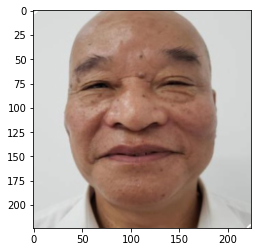

pred: 1 label: 2


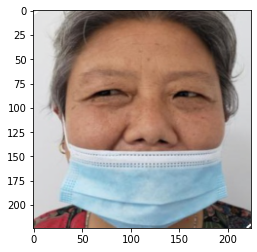

pred: 1 label: 2


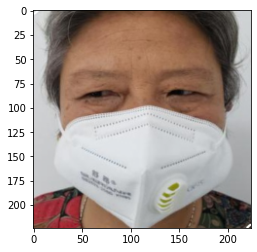

pred: 1 label: 2


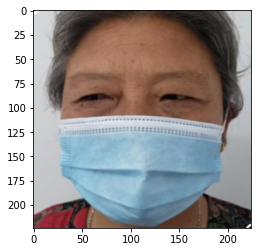

pred: 1 label: 2


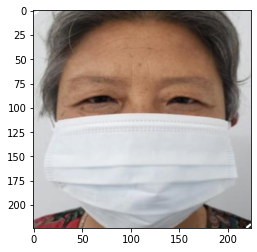

pred: 1 label: 2


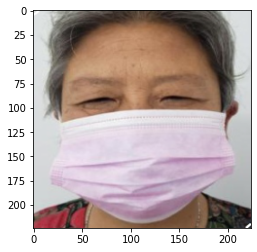

pred: 1 label: 2


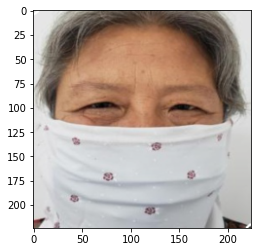

pred: 1 label: 2


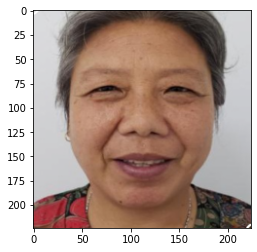

pred: 1 label: 2


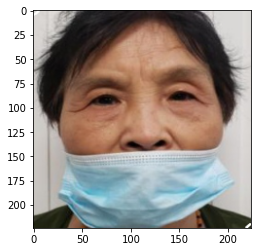

pred: 1 label: 2


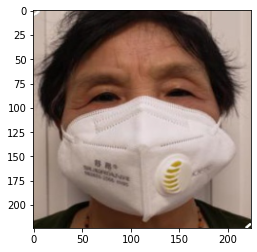

pred: 1 label: 2


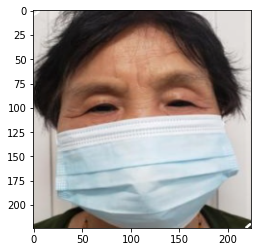

pred: 1 label: 2


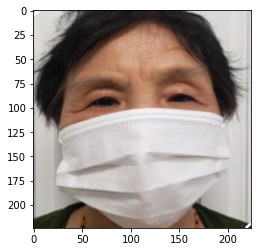

pred: 1 label: 2


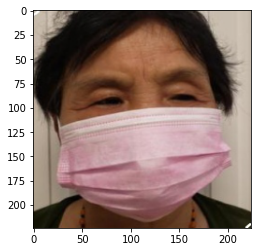

pred: 1 label: 2


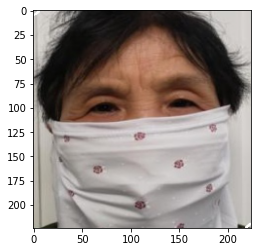

pred: 1 label: 2


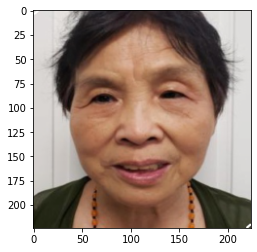

pred: 1 label: 2


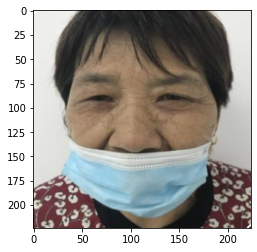

pred: 1 label: 2


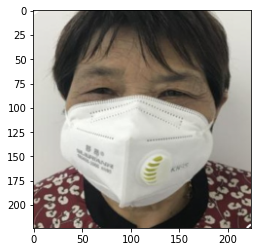

pred: 1 label: 2


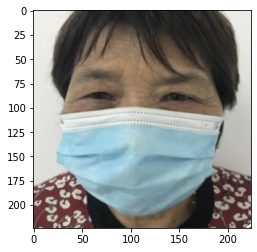

pred: 1 label: 2


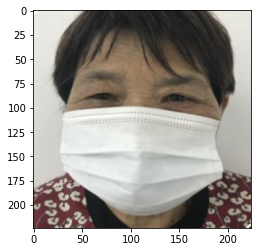

pred: 1 label: 2


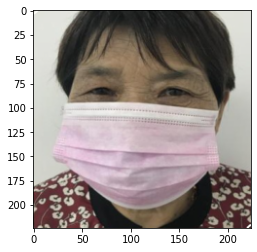

pred: 1 label: 2


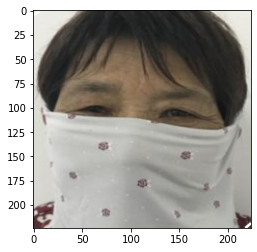

pred: 1 label: 2


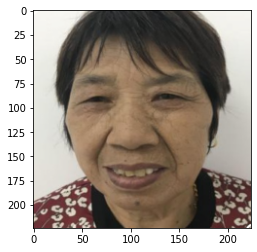

In [19]:
for p, l, im in zip(v_p_a, v_l_a, v_i_a):
    if p != l:
        pred = a_c[p]
        label = a_c[l]
        
        im = im.transpose((1, 2, 0))
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        im = std * im + mean
        im = np.clip(im, 0, 1)
        
        print(f'pred: {pred} label: {label}')
        plt.imshow(im)
        plt.show()

In [20]:
submission = submission.astype({'age':'int','gender':'int','mask':'int'})

In [21]:
try : submission['ans'] = submission['mask'] + submission['gender'] + submission['age'] ; submission2 = submission.drop(['mask','gender','age'],axis=1)
except : pass
submission2

ImageID  ans
0      cbc5c6e168e63498590db46022617123f1fe1268.jpg   13
1      0e72482bf56b3581c081f7da2a6180b8792c7089.jpg    1
2      b549040c49190cedc41327748aeb197c1670f14d.jpg   13
3      4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg   13
4      248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg   12
...                                             ...  ...
12595  d71d4570505d6af8f777690e63edfa8d85ea4476.jpg    1
12596  6cf1300e8e218716728d5820c0bab553306c2cfd.jpg    4
12597  8140edbba31c3a824e817e6d5fb95343199e2387.jpg    9
12598  030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg    0
12599  f1e0b9594ae9f72571f0a9dc67406ad41f2edab0.jpg    7

[12600 rows x 2 columns]

In [22]:
submission2.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)